<a href="https://colab.research.google.com/github/dennis-ancajima/ML-PUCP/blob/main/04_Modelo_Entrenamiento_BasePaper_SVMCubic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En el presente notebook vamos a realizar la reproducción de la experimentación del estudio de Celik, Guney y Dengiz (2021), quienes aplicaron diferentes métodos de clasificación para estimar los niveles de obesidad con un conjunto de datos conformado por 2111 datos y 12 características, obteniendo  una precisión (accuracy) de **97,8%** usando el modelo **SVM Cúbico.**





 **Tabla de contenido:**

1. Cargar datos.
2. Pre - procesamiento.

  2.1. Codificación de variables categóricas.

  2.2. Selección de características.

  2.3. Eliminación características con menor score.

3. Modelado.
4. Evaluación de Resultados
5. Referencias.



# 1. Cargar datos

En primero lugar, realizamos la importación de librerías y módulos necesarios para el análisis de datos y aprendizaje automático.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt #visualizaciones
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
import seaborn as sns #Libreria para gráficar
from sklearn.model_selection import cross_val_score
from google.colab import drive

pd.set_option("display.max_columns", 50) #Controla la cantidad máxima de columnas que se mostrarán al imprimir un DataFrame.

%matplotlib inline
plt.style.use('ggplot')

Realizamos la lectura del archivo CSV "ObesityDataSet_raw_and_data_sinthetic.csv" y los almacenamos en la variable **dataset** utilizando la función **read_csv()** de la biblioteca panda.


In [8]:
#Lectura del dataset
archivo = "ObesityDataSet_raw_and_data_sinthetic.csv"

#El método "read_csv" nos permite leer un excel
dataset = pd.read_csv(archivo)

Veamos las primeras 5 filas del conjunto de datos almacenado en la variable **dataset**.

In [9]:
dataset.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


# 2. Pre - procesamiento

Según el estudio no consideran limpieza de la data, validamos que existen 24 datos duplicados, pero son considerados dentro del entrenamiento.

In [10]:
#Revisando duplicados
dataset.duplicated().sum()

24

## 2.1. Codificación de variables categóricas.

Como parte del pre-procesamiento utilizaron **LabelEncoder** para convertir los datos categóricos en númericos. Siendo un paso importante de pre-procesamiento para luego aplicar los algoritmos de clasificación con características numéricas.

In [11]:
#Se importa la clase LabelEncoder desde sklearn.preprocessing para poder utilizarla en el código.
from sklearn.preprocessing import LabelEncoder

#Se define una lista cols_categoricas que contiene los nombres de las columnas del dataset que contienen variables categóricas que se desean transformar.
cols_categoricas = ['CAEC','CALC','MTRANS','FAVC', 'SMOKE', 'SCC','family_history_with_overweight','Gender','NObeyesdad']

#Se itera sobre cada columna categórica en cols_categoricas utilizando un bucle for.
for c in cols_categoricas:
  #Se crea una instancia de LabelEncoder llamada lbl.
    lbl = LabelEncoder()
    # Se utiliza el método fit_transform() de LabelEncoder para ajustar y transformar la columna categórica del dataset.
    #Esto asigna un valor numérico único a cada categoría presente en la columna.
    dataset[c] = lbl.fit_transform(dataset[c])
# Se imprime la forma del dataset después de aplicar las transformaciones.
print('Shape all_data: {}'.format(dataset.shape))

Shape all_data: (2111, 17)


## 2.2. Selección de características: Eliminación recursiva de características.


Aplicaron selección de características importantes al conjunto de datos usando el método  **Backward feature elimination** (Eliminación hacia atrás) con validación cruzada de 10 divisiones. Esto con la finalidad de reducir el número de características y eliminar data irrelevante. Las características: CALC, MTRANS, FCVC y family_history_with_overweight fueron eliminadas de las 16 características, según el estudio de Celik, Guney y Dengiz (2021).

In [12]:
#Separamos la data, en variables independientes (X_train_val) y dependientes (y_train_val), para poder aplicar el método de eliminación hacia atrás.
X_train_val = dataset.drop(['NObeyesdad'], axis=1)
y_train_val = dataset['NObeyesdad']

Se debe escalar los datos antes de aplicar el método de selección de características: siendo la media igual a 0 y la varianza igual a 1. Podemos hacerlo usando la función **scaler** de la biblioteca sklearn:

In [13]:
#Creamos la instancia de StandardScaler llamada scaler
scaler = StandardScaler()

#Ajuste y transformación de datos de entrenamiento a través del método fit_transform(), método que aplica una estandarización.
X_train_scal = scaler.fit_transform(X_train_val)


Para aplicar el método de eliminación recursiva de características elegimos los modelos RandomForestClassifier y LinearSVC, ya que tienen atributos como **feature_importances_** o **coef_** respectivamente.

Usando como estimador el modelo **RandomForest**, se obtiene:

[True, True]
Número de características óptimas: 2


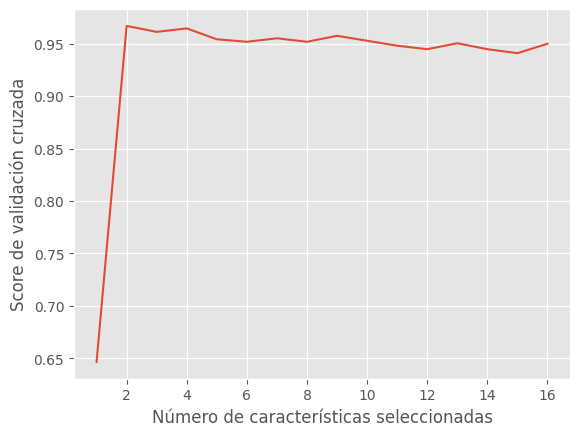

In [14]:
#Importación de librerías y módulos necesarios para aplicar Eliminación recursiva.
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#Definimos el estimador utilizado en RFECV como un RandomForestClassifier con bagging.
estimator=RandomForestClassifier(oob_score = True, random_state=42)

#Creamos un objeto RFECV con el estimador definido, utilizando una validación cruzada de 10 divisiones y el puntaje de precisión (accuracy) como métrica de evaluación.
rfecv = RFECV(estimator, cv=10,scoring='accuracy' )

#Ajuste del objeto a los datos de entranimiento escalados.
rfecv.fit(X_train_scal, y_train_val)

#Obtenemos las características seleccionadas.
selected_features = rfecv.support_

#Imprime las características seleccionadas (selected_feature_names) y el número óptimo de características (rfecv.n_features_).
selected_feature_names = [feature for feature, selected in zip(selected_features, selected_features) if selected]
print(selected_feature_names)
print("Número de características óptimas: %d" % rfecv.n_features_)

#Se crea un gráfico para visualizar el rendimiento de la validación cruzada en función del número de características seleccionadas.
plt.figure()
plt.xlabel("Número de características seleccionadas")
plt.ylabel("Score de validación cruzada")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

A continuación, visualizamos las 2 características óptimas según el modelo random Forest.

In [15]:
# Obtener las características seleccionadas
selected_features = rfecv.support_

# Obtener los nombres de todas las características originales
all_feature_names = ['Gender', 'Age', 'Height', 'Weight','family_history_with_overweight','FAVC','FCVC','NCP','CAEC','SMOKE','CH2O','SCC','FAF','TUE','CALC','MTRANS']

# Obtener los nombres de las características seleccionadas
selected_feature_names = [name for name, selected in zip(all_feature_names, selected_features) if selected]

# Imprimir las mejores características
print("Mejores características seleccionadas:")
for name in selected_feature_names:
  print(name)

Mejores características seleccionadas:
Height
Weight


A continuación, visualizamos las 4 características según Random Forest con menor score: 'SMOKE', 'SCC', 'FAVC', 'MTRANS'

In [16]:
# Obtiene los rankings de las características
feature_ranking = rfecv.ranking_

# Crea una lista de tuplas con el nombre de la característica y su ranking.
feature_ranking_tuples = [(feature, rank) for feature, rank in zip(dataset.columns, feature_ranking)]

# Ordena las características por ranking en orden descendente.
sorted_features = sorted(feature_ranking_tuples, key=lambda x: x[1], reverse=True)

# Obtenemos las 4 características con menor score (mayor ranking)
features_to_remove = [feature for feature, rank in sorted_features[:4]]
features_to_remove

['SMOKE', 'SCC', 'FAVC', 'MTRANS']

Usando como estimador el modelo **SVC lineal**, se obtiene:

[True, True, True, True, True]
Número de características óptimas: 5


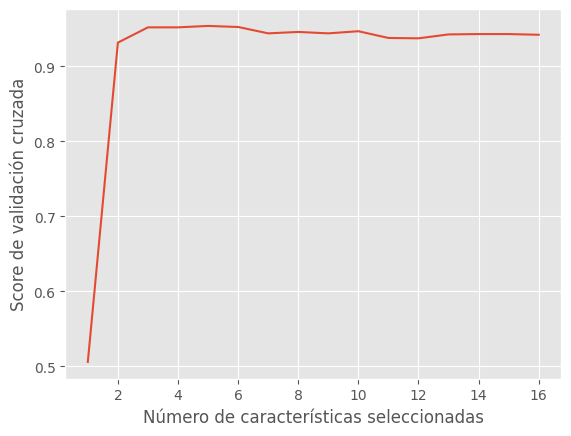

In [17]:
#Importación de librerías y módulos necesarios para aplicar Eliminación recursiva.
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.metrics import accuracy_score

#Definimos el estimador utilizado en RFECV como un SVM lineal.
estimator = SVC(kernel="linear")

#Creamos un objeto RFECV con el estimador definido, utilizando una validación cruzada de 10 divisiones y el puntaje de precisión (accuracy) como métrica de evaluación.
rfecv = RFECV(estimator, cv=10,scoring='accuracy' )

#Ajuste del objeto a los datos de entranimiento escalados.
rfecv.fit(X_train_scal, y_train_val)

#Obtenemos las características seleccionadas.
selected_features = rfecv.support_

#Imprime las características seleccionadas (selected_feature_names) y el número óptimo de características (rfecv.n_features_).
selected_feature_names = [feature for feature, selected in zip(selected_features, selected_features) if selected]
print(selected_feature_names)
print("Número de características óptimas: %d" % rfecv.n_features_)

#Se crea un gráfico para visualizar el rendimiento de la validación cruzada en función del número de características seleccionadas.
plt.figure()
plt.xlabel("Número de características seleccionadas")
plt.ylabel("Score de validación cruzada")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

A continuación, visualizamos las 4 características según SVM lineal con menor score: 'SMOKE', 'SCC', 'TUE', 'FAVC'

In [18]:
# Obtener los rankings de las características
feature_ranking = rfecv.ranking_

# Crear una lista de tuplas con el nombre de la característica y su ranking
feature_ranking_tuples = [(feature, rank) for feature, rank in zip(dataset.columns, feature_ranking)]

# Ordenar las características por ranking en orden descendente
sorted_features = sorted(feature_ranking_tuples, key=lambda x: x[1], reverse=True)

# Obtenemos las 4 características con menor score (mayor ranking)
features_to_remove = [feature for feature, rank in sorted_features[:4]]
features_to_remove


['SMOKE', 'SCC', 'TUE', 'FAVC']

En resumen, las características con menor score según **Random Forest** son: 'SMOKE', 'SCC', 'FAVC', 'MTRANS' y según **SVM lineal** son: 'SMOKE', 'SCC', 'TUE', 'FAVC'. Sin embargo, según el estudio de Celik, Guney y Dengiz (2021) determinaron eliminaron las siguientes 4 de las 16 características: CALC, MTRANS, FCVC y family_history_with_overweight ya que se consideran irrelevantes para efectos de la predicción.

## 2.3. Eliminación características con menor score.

A continuación, se procede a eliminar las 4 características mencionadas:

In [19]:
dataset.drop(['CALC','MTRANS','FCVC','family_history_with_overweight'], axis=1, inplace=True)

El conjunto de datos quedaría de la siguiente forma:

In [20]:
dataset.head()

,Gender,Age,Height,Weight,FAVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,NObeyesdad
0,0,21.0,1.62,64.0,0,3.0,2,0,2.0,0,0.0,1.0,1
1,0,21.0,1.52,56.0,0,3.0,2,1,3.0,1,3.0,0.0,1
2,1,23.0,1.80,77.0,0,3.0,2,0,2.0,0,2.0,1.0,1
3,1,27.0,1.80,87.0,0,3.0,2,0,2.0,0,2.0,0.0,5
4,1,22.0,1.78,89.8,0,1.0,2,0,2.0,0,0.0,0.0,6


# 3. Modelado

## 3.1. División de datos de entrenamiento y test

In [21]:
#Separamos la data, en variables independientes (x) y dependientes (y), para poder entrenar el modelo de regresión
X_train_val = dataset.drop(['NObeyesdad'], axis=1)
y_train_val = dataset['NObeyesdad']

Decidieron utilizar el 80\% de los datos para el entrenamiento y el 20\% para la validación.

In [22]:
# Dividimos la data en conjunto de "entrenamiento" y "prueba"
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

In [23]:
#12 características, observamos el tamaño actual de los datos de entrenamiento y de validación.
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_val.shape}")

Train shape: (1688, 12)
Test shape: (423, 12)


## 3.2. Modelo SVM Cúbico.

Decidieron utilizar el método **StandardScaler** para escalar los datos: siendo la media igual a 0 y la varianza igual a 1.

In [24]:
# Se crea un objeto de la clase StandardScaler de la librería scikit-learn.
scaler = StandardScaler()

X_train_scal = scaler.fit_transform(X_train) #Escalar los datos de entrenamiento
X_val_scal = scaler.fit_transform(X_val) #Escalar los datos de prueba

Se considera valor **C=10 y gamma=50**.

In [25]:
# Tomado de notebook trabajado en clase "SVM - Ejercicio.ipynb"
from sklearn import svm
#Importa la función accuracy_score del módulo sklearn.metrics, que se utilizará para calcular la precisión del modelo.
from sklearn.metrics import accuracy_score

# Crea una instancia del clasificador SVM utilizando el kernel cúbico.
model = svm.SVC(kernel='poly', degree=3,C=10, gamma=50)

# Entrenamiento del clasificador
model.fit(X_train_scal, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_val_scal)

#Realiza una validación cruzada de 10 divisiones utilizando el modelo SVM y los datos de entrenamiento escalados.
cv = cross_val_score(estimator = model, X = X_train_scal, y = y_train, cv = 10)

#Calcula la media de las puntuaciones de rendimiento obtenidas en la validación cruzada.
cvForest = cv.mean()
# Calcula la desviación estándar de las puntuaciones de rendimiento obtenidas en la validación cruzada.
stdForest = cv.std()


print("promedio Validación cruzada k=10: ", cvForest)
print('Varianza de SVM Cúbico: ',stdForest)
print ('Exactitud en el conjunto de entrenamiento: %0.4f' % model.score(X_train_scal, y_train))
print ('Exactitud en el conjunto de validación: %0.4f' % model.score(X_val_scal, y_val))

promedio Validación cruzada k=10:  0.8928043110735417
Varianza de SVM Cúbico:  0.031750143766294425
Exactitud en el conjunto de entrenamiento: 1.0000
Exactitud en el conjunto de validación: 0.8794


Se tiene una exactitud muy alta en el conjunto de entrenamiento (1.0000), sin embargo la exactitud es bastante menor en el conjunto de validación (0.8794). Este es un síntoma claro de sobreajuste (overfitting).



Por ello, se va a determinar valores óptimos para C y γ que nos brinden una mejor generalización, es necesario probar con diferentes valores, ajustando el modelo en el conjunto de entrenamiento y probando su rendimiento en el conjunto de validación.

In [26]:
# Tomado de notebook trabajado en clase "SVM - Ejercicio.ipynb"
from sklearn import svm
#Importa la función accuracy_score del módulo sklearn.metrics, que se utilizará para calcular la precisión del modelo.
from sklearn.metrics import accuracy_score

#Crea una lista de valores de hiperparámetro C utilizando la función logspace de NumPy. En este caso, se generan 9 valores equiespaciados en una escala logarítmica desde 0.01 hasta 100.
Cs = np.logspace(-2,2,9)  # ~ [0.01, 0.03, 0.1, ..., 100]
#Crea una lista de valores de hiperparámetro gamma de manera similar a la lista de valores de C.
gammas = np.logspace(-4,4,9)  # [0.0001, 0.001, ..., 10000]

mejor_modelo = None
mejor_score = 0
for C in Cs:
    for gamma in gammas:
        #Crea una instancia del clasificador SVM con kernel cúbic
        model = svm.SVC(kernel='poly', degree=3, C=C, gamma=gamma)
        model.fit(X_train_scal, y_train)

        # Calcula el puntaje de precisión del modelo en el conjunto de validación.
        score_val = model.score(X_val_scal, y_val)

        #Compara el puntaje de precisión actual con el mejor puntaje encontrado hasta ahora.
        if score_val > mejor_score:
            mejor_score = score_val
            mejor_modelo = model

#Realiza una validación cruzada de 10 divisiones utilizando el mejor modelo encontrado.
cv = cross_val_score(estimator = mejor_modelo, X = X_train_scal, y = y_train, cv = 10)
#Calcula la media de los puntajes de validación cruzada obtenidos.
cvForest = cv.mean()

print ('Mejor valor de C: %0.4f' % mejor_modelo.get_params()['C'])
print ('Mejor valor de gamma: %0.4f' % mejor_modelo.get_params()['gamma'])
print ('Exactitud en el conjunto de entrenamiento: %0.4f' % mejor_modelo.score(X_train_scal, y_train))
print ('Exactitud en el conjunto de validación: %0.4f' % mejor_modelo.score(X_val_scal, y_val))
print("promedio Validación cruzada k=10: ", cvForest)


Mejor valor de C: 0.0316
Mejor valor de gamma: 1.0000
Exactitud en el conjunto de entrenamiento: 0.9929
Exactitud en el conjunto de validación: 0.8889
promedio Validación cruzada k=10:  0.889845731191885


Ahora, se realizará el entrenamiento con los mejores valores, siendo  **C=0.0316 y gamma=1.**

In [27]:
# Tomado de notebook trabajado en clase "SVM - Ejercicio.ipynb"
from sklearn import svm
#Importa la función accuracy_score del módulo sklearn.metrics, que se utilizará para calcular la precisión del modelo.
from sklearn.metrics import accuracy_score

# Crea una instancia del clasificador SVM utilizando el kernel cúbico.
model = svm.SVC(kernel='poly', degree=3,C=0.0316, gamma=1)

# Entrenamiento del clasificador
model.fit(X_train_scal, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_val_scal)

#Realiza una validación cruzada de 10 divisiones utilizando el modelo SVM y los datos de entrenamiento escalados.
cv = cross_val_score(estimator = model, X = X_train_scal, y = y_train, cv = 10)

#Calcula la media de las puntuaciones de rendimiento obtenidas en la validación cruzada.
cvForest = cv.mean()
# Calcula la desviación estándar de las puntuaciones de rendimiento obtenidas en la validación cruzada.
stdForest = cv.std()


print("promedio Validación cruzada k=10: ", cvForest)
print('Varianza de SVM Cúbico: ',stdForest)
print ('Exactitud en el conjunto de entrenamiento: %0.4f' % model.score(X_train_scal, y_train))
print ('Exactitud en el conjunto de validación: %0.4f' % model.score(X_val_scal, y_val))

promedio Validación cruzada k=10:  0.889845731191885
Varianza de SVM Cúbico:  0.026654837637503745
Exactitud en el conjunto de entrenamiento: 0.9929
Exactitud en el conjunto de validación: 0.8889


# 4. Evaluación de Resultados

## 4.1. Matriz de confusión

Para la evaluación del modelo usaremos la matriz de confusión ya que proporciona información detallada sobre los aciertos y errores del modelo.

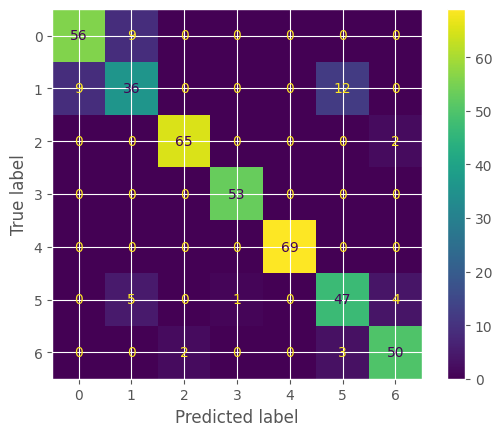

In [29]:
cm = confusion_matrix(y_val, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

Como conclusión se obtuvo una exactitud en el conjunto de validación de **0.8889** usando el modelo **SVM Cubic**, con 12 características.

# Referencias:

1. Celik, Y., Guney, S., & Dengiz, B. (2021). Obesity level estimation based on machine learning methods and artificial neural networks. En 44th International Conference on Telecommunications and Signal Processing (TSP), páginas 329-332. IEEE.

# Ensamble por votación manual

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm

estimators = [
     ('Random Forest', make_pipeline(StandardScaler(), RandomForestClassifier(oob_score = True, random_state=42))),
     ('SVM Cubic', make_pipeline(StandardScaler(),svm.SVC(kernel='poly', degree=3,C=10, gamma=50,probability=True))),

     ('árbol de decisión', DecisionTreeClassifier(max_depth=4)),
     ('k-NN', make_pipeline(StandardScaler(),
                            KNeighborsClassifier(n_neighbors=7) )),
     ('SVM de kernel gaussiano', make_pipeline(StandardScaler(),
                                               SVC(kernel='rbf', probability=True) ))
]

ensamble = VotingClassifier(estimators=estimators,
                        voting='soft', weights=[3,2,2, 1, 2])
ensamble.fit(X_train, y_train)

for (name, estimator) in ensamble.named_estimators_.items():
  print(f'Exactitud de {name: <25}: Entrenamiento {estimator.score(X_train, y_train):.03f} || Pruebas {estimator.score(X_val, y_val):.03f}',  )

print(f'Exactitud de {"ensamble": <25}: Entrenamiento {ensamble.score(X_train, y_train):.03f} || Validación {ensamble.score(X_val, y_val):.03f}' )

Exactitud de Random Forest            : Entrenamiento 1.000 || Pruebas 0.953
Exactitud de SVM Cubic                : Entrenamiento 1.000 || Pruebas 0.896
Exactitud de árbol de decisión        : Entrenamiento 0.803 || Pruebas 0.785
Exactitud de k-NN                     : Entrenamiento 0.837 || Pruebas 0.766
Exactitud de SVM de kernel gaussiano  : Entrenamiento 0.927 || Pruebas 0.896
Exactitud de ensamble                 : Entrenamiento 0.993 || Validación 0.931


**RandomForest con data escalada: OOB (Bagging)**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(oob_score = True,random_state=42)
rf.fit(X_train_scal, y_train)

y_pred = rf.predict(X_val_scal) #Hacemos predicciones sobre el conjunto de test

cv = cross_val_score(estimator = rf, X = X_train_scal, y = y_train, cv = 10) #metodo para obtener la precisión
cvForest = cv.mean()
stdForest = cv.std()
print('Exactitud del modelo inicial en entrenamiento:', rf.score(X_train_scal, y_train))
print('Exactitud del modelo inicial en entrenamiento (Out of Bag):', rf.oob_score_)
print('Exactitud del modelo inicial en validación:', rf.score(X_val_scal, y_val))
print("promedio Validación cruzada Random Forest: ", cvForest)
print('Varianza de Random Forest: ',stdForest)

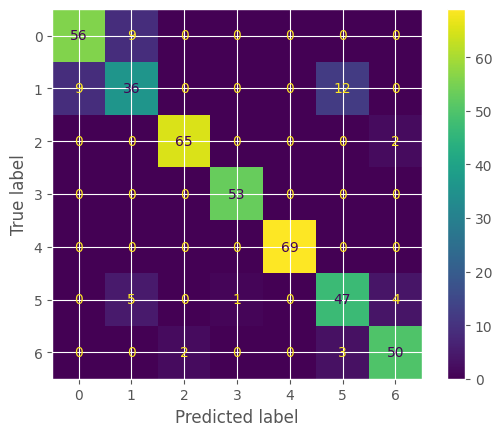

In [28]:
cm = confusion_matrix(y_val, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

# Importancia de la características

In [ ]:
feature_names = X_train_val.columns.values
tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Importancia de características")
fig.tight_layout()
plt.show()

** Estrategia De Validación A Emplear Para El Ajuste De Hiperparámetros.**

Los principales hiperparámetros de Random Forest son:

n_estimators -- el número de modelos base (árboles) a entrenar
max_features -- el número de características a considerar en cada partición de los árboles
max_depth -- la profundidad máxima de los árboles
min_samples_leaf -- el numero mínimo de muestras que deben quedar en cada hoja del árbol
Para identificar los mejores valores de los hiperparámetros usaremos primero búsqueda aleatoria y luego búsqueda en grilla.

In [ ]:
from pprint import pprint
import numpy as np

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 8, 10, 12, None]  # 'auto' equivale a 'sqrt'; None equivale a todas las 15
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] + [None]
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

print('Los valores a probar en la búsqueda aleatoria son:')
pprint(random_grid)

print()
print('Si se probara todas las combinaciones se requeriría entrenar',
      len(random_grid['n_estimators']) *
      len(random_grid['max_features']) *
      len(random_grid['max_depth']) *
      len(random_grid['min_samples_leaf']),
      'modelos'
      )

Probaremos entrenando sólo un 1% de las combinaciones posibles, es decir, 18. (Se recomienda probar al menos un 10%)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(oob_score=True)
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 18,
                               cv = 10,          # Validación cruzada 10-fold
                               verbose=2,
                               random_state=0,
                               n_jobs = -1      # Paralelizar en todos los cores disponibles
                               )
rf_random.fit(X_train_scal, y_train)

In [ ]:
rf_random_best = rf_random.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(rf_random.best_params_)
print()

print('Exactitud luego de búsqueda aleatoria en entrenamiento:', rf_random_best.score(X_train_scal, y_train))
print('Exactitud luego de búsqueda aleatoria en entrenamiento (Out of Bag):', rf_random_best.oob_score_)
print('Exactitud luego de búsqueda aleatoria en validación:', rf_random_best.score(X_val_scal, y_val))

Para la evaluación de resultados de pruebas usaron validación cruzada, determinando k=10

Matriz de confusión.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix,
            annot=True,
            xticklabels = sorted(set(y_test)),
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()